In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import torch.utils.data as data

import random
import math
import time

from tqdm import tqdm

import matplotlib.pyplot as plt

import json

In [2]:
en_file = 'data/en-US.jsonl'

def read_data(path):
    with open(path, 'r') as file:
        return pd.DataFrame([json.loads(line) for line in file])

df = read_data(en_file)
df.head()


,id,locale,partition,scenario,intent,utt,annot_utt,worker_id
0,0,en-US,test,alarm,alarm_set,wake me up at five am this week,wake me up at [time : five am] [date : this week],1
1,1,en-US,train,alarm,alarm_set,wake me up at nine am on friday,wake me up at [time : nine am] on [date : friday],1
2,2,en-US,train,alarm,alarm_set,set an alarm for two hours from now,set an alarm for [time : two hours from now],1
3,3,en-US,test,audio,audio_volume_mute,quiet,quiet,1
4,4,en-US,train,audio,audio_volume_mute,olly quiet,olly quiet,1


In [106]:
def categories(df, label):
    return set(df[label])


def df_select(df, col, label):
    return df[df[col] == label]


def categorize(df, label, f):
    C = categories(df, label)
    return { c: f((df, label, c)) for c in C }


def hierarchy(df, columns, type = 'root', value=None, f=lambda x: None):
    # a useful f function:
    # f = lambda x: df_select(*x)

    if value:
        df = df_select(df, type, value) 

    sub = col = None
    
    if len(columns) > 0:
        col = columns[0]

        C = categorize(df, col, f)
        sub = { c: hierarchy(df, columns[1:], col, c, f) for c in C }
    
    return {
        'name': value,
        'category': type,
        'children_type': col,
        'children': sub,
        'data': df,
        }


def hierarchy_drop_data(h):
    if type(h) != dict:
        return h
    
    return { k: hierarchy_drop_data(v) for k,v in h.items() if k != 'data' and not (type(v) == dict and len(v) == 0)}


def hierarchy_tree(df, column_sequence):
    def count_dict(h):
        if not h:
            return None
        if not h['children']:
            return None
        
        children = { child : len(h_child['data']) for child, h_child in h['children'].items() if child and h_child }
        return children
    
    def tree(h):
        if not h:
            return None
        
        counts = count_dict(h)
        children = { child : tree(value) for child, value in h['children'].items() } if h['children'] else None
        
        return {
            'counts': counts,
            'subtrees': children
        }
    
    h = hierarchy(df, column_sequence)
    return tree(h)
    

def count_tree_leaves(t):
    count = 0
    
    if not t['subtrees']:
        return 1
    
    for _, subtree in t['subtrees'].items():
        count += count_tree_leaves(subtree)

    return count

# use this
# h = hierarchy(df, ['scenario', 'intent', 'utt'])
t = hierarchy_tree(df, ['scenario', 'intent', 'utt'][0:1])

In [107]:
t

{'counts': {'qa': 1685,
  'alarm': 550,
  'social': 565,
  'takeaway': 358,
  'music': 469,
  'audio': 387,
  'general': 963,
  'calendar': 2370,
  'transport': 805,
  'lists': 793,
  'weather': 855,
  'recommendation': 596,
  'news': 709,
  'datetime': 578,
  'iot': 1107,
  'email': 1381,
  'cooking': 326,
  'play': 2024},
 'subtrees': {'qa': {'counts': None, 'subtrees': None},
  'alarm': {'counts': None, 'subtrees': None},
  'social': {'counts': None, 'subtrees': None},
  'takeaway': {'counts': None, 'subtrees': None},
  'music': {'counts': None, 'subtrees': None},
  'audio': {'counts': None, 'subtrees': None},
  'general': {'counts': None, 'subtrees': None},
  'calendar': {'counts': None, 'subtrees': None},
  'transport': {'counts': None, 'subtrees': None},
  'lists': {'counts': None, 'subtrees': None},
  'weather': {'counts': None, 'subtrees': None},
  'recommendation': {'counts': None, 'subtrees': None},
  'news': {'counts': None, 'subtrees': None},
  'datetime': {'counts': None, 

In [ ]:
leaf_count = count_tree_leaves(t)


<BarContainer object of 18 artists>

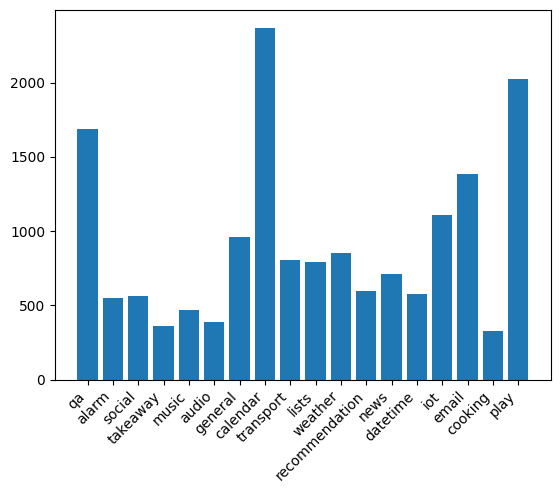

In [48]:
plt.xticks(rotation=45, ha='right')
plt.bar(t.keys(), t.values())

In [43]:
# set(h['children']['qa']['data']['scenario'])
h

{'name': None,
 'category': 'root',
 'children_type': 'scenario',
 'children': {'qa': {'name': 'qa',
   'category': 'scenario',
   'children_type': 'intent',
   'children': {'qa_factoid': {'name': 'qa_factoid',
     'category': 'intent',
     'children_type': 'utt',
     'children': None,
     'data':           id locale partition scenario      intent  \
     1737    1801  en-US     train       qa  qa_factoid   
     4656    4822  en-US       dev       qa  qa_factoid   
     4802    4968  en-US      test       qa  qa_factoid   
     4803    4969  en-US     train       qa  qa_factoid   
     5054    5233  en-US     train       qa  qa_factoid   
     ...      ...    ...       ...      ...         ...   
     14557  15128  en-US     train       qa  qa_factoid   
     14558  15129  en-US     train       qa  qa_factoid   
     14559  15130  en-US     train       qa  qa_factoid   
     14560  15131  en-US     train       qa  qa_factoid   
     14561  15132  en-US     train       qa  qa_facto

In [33]:
h['children']

{'qa': {'name': 'qa',
  'category': 'scenario',
  'children_type': 'intent',
  'children': {},
  'data': {}},
 'alarm': {'name': 'alarm',
  'category': 'scenario',
  'children_type': 'intent',
  'children': {},
  'data': {}},
 'social': {'name': 'social',
  'category': 'scenario',
  'children_type': 'intent',
  'children': {},
  'data': {}},
 'takeaway': {'name': 'takeaway',
  'category': 'scenario',
  'children_type': 'intent',
  'children': {},
  'data': {}},
 'music': {'name': 'music',
  'category': 'scenario',
  'children_type': 'intent',
  'children': {},
  'data': {}},
 'audio': {'name': 'audio',
  'category': 'scenario',
  'children_type': 'intent',
  'children': {},
  'data': {}},
 'general': {'name': 'general',
  'category': 'scenario',
  'children_type': 'intent',
  'children': {},
  'data': {}},
 'calendar': {'name': 'calendar',
  'category': 'scenario',
  'children_type': 'intent',
  'children': {},
  'data': {}},
 'transport': {'name': 'transport',
  'category': 'scenario'

In [5]:
p = hierarchy_drop_data(h)

In [10]:
p['children']

{'qa': {'name': 'qa', 'category': 'scenario', 'children_type': 'intent'},
 'alarm': {'name': 'alarm', 'category': 'scenario', 'children_type': 'intent'},
 'social': {'name': 'social',
  'category': 'scenario',
  'children_type': 'intent'},
 'takeaway': {'name': 'takeaway',
  'category': 'scenario',
  'children_type': 'intent'},
 'music': {'name': 'music', 'category': 'scenario', 'children_type': 'intent'},
 'audio': {'name': 'audio', 'category': 'scenario', 'children_type': 'intent'},
 'general': {'name': 'general',
  'category': 'scenario',
  'children_type': 'intent'},
 'calendar': {'name': 'calendar',
  'category': 'scenario',
  'children_type': 'intent'},
 'transport': {'name': 'transport',
  'category': 'scenario',
  'children_type': 'intent'},
 'lists': {'name': 'lists', 'category': 'scenario', 'children_type': 'intent'},
 'weather': {'name': 'weather',
  'category': 'scenario',
  'children_type': 'intent'},
 'recommendation': {'name': 'recommendation',
  'category': 'scenario',


In [157]:
# h['categories']['email']['data']
# h.keys()
# h['categories'].keys()
# h['categories']['email'].keys()
# h['categories']['email']['name']
# h['categories']['email']['column']
p hierarchy_drop_data(h)

{'name': None,
 'category': 'root',
 'children_type': 'scenario',
 'children': {'email': {'name': 'email',
   'category': 'scenario',
   'children_type': 'intent'},
  'weather': {'name': 'weather',
   'category': 'scenario',
   'children_type': 'intent'},
  'alarm': {'name': 'alarm',
   'category': 'scenario',
   'children_type': 'intent'},
  'takeaway': {'name': 'takeaway',
   'category': 'scenario',
   'children_type': 'intent'},
  'news': {'name': 'news', 'category': 'scenario', 'children_type': 'intent'},
  'qa': {'name': 'qa', 'category': 'scenario', 'children_type': 'intent'},
  'recommendation': {'name': 'recommendation',
   'category': 'scenario',
   'children_type': 'intent'},
  'play': {'name': 'play', 'category': 'scenario', 'children_type': 'intent'},
  'transport': {'name': 'transport',
   'category': 'scenario',
   'children_type': 'intent'},
  'iot': {'name': 'iot', 'category': 'scenario', 'children_type': 'intent'},
  'music': {'name': 'music',
   'category': 'scenario'

In [139]:
def g(h):
    return h['type'], h['value'], h['next_column']

g(h['categories']['email'])

('scenario', 'email', 'intent')

In [137]:
h['data']

{'email':           id locale partition scenario           intent  \
 4390    4539  en-US     train    email  email_sendemail   
 6285    6510  en-US     train    email      email_query   
 6938    7177  en-US     train    email  email_sendemail   
 6939    7178  en-US     train    email  email_sendemail   
 7107    7353  en-US      test    email      email_query   
 ...      ...    ...       ...      ...              ...   
 16516  17176  en-US     train    email      email_query   
 16517  17177  en-US     train    email      email_query   
 16518  17178  en-US     train    email      email_query   
 16519  17179  en-US      test    email      email_query   
 16520  17180  en-US     train    email      email_query   
 
                                                      utt  \
 4390   i did not want you to send that text yet wait ...   
 6285                                              emails   
 6938   please send a mail to mr. richard stating that...   
 6939   please send a voi

In [50]:
d['scenario']['alarm']['alarm_set']

,id,locale,partition,scenario,intent,utt,annot_utt,worker_id
0,0,en-US,test,alarm,alarm_set,wake me up at five am this week,wake me up at [time : five am] [date : this week],1
1,1,en-US,train,alarm,alarm_set,wake me up at nine am on friday,wake me up at [time : nine am] on [date : friday],1
2,2,en-US,train,alarm,alarm_set,set an alarm for two hours from now,set an alarm for [time : two hours from now],1
92,93,en-US,train,alarm,alarm_set,set an alarm for twelve,set an alarm for [time : twelve],221
93,94,en-US,train,alarm,alarm_set,set an alarm forty minutes from now,set an alarm [time : forty minutes from now],221
...,...,...,...,...,...,...,...,...
8657,8945,en-US,train,alarm,alarm_set,add alarm,add alarm,625
8754,9044,en-US,train,alarm,alarm_set,make an alarm for five p. m. on tuesday,make an alarm for [time : five p. m.] on [date...,658
8755,9045,en-US,train,alarm,alarm_set,alarm five p. m. tuesday,alarm [time : five p. m.] [date : tuesday],658
8759,9049,en-US,dev,alarm,alarm_set,set an alarm for four p. m. tuesday,set an alarm for [time : four p. m.] [date : t...,658


In [22]:
sub['audio']

,id,locale,partition,scenario,intent,utt,annot_utt,worker_id
3,3,en-US,test,audio,audio_volume_mute,quiet,quiet,1
4,4,en-US,train,audio,audio_volume_mute,olly quiet,olly quiet,1
5,5,en-US,train,audio,audio_volume_mute,stop,stop,1
6,6,en-US,train,audio,audio_volume_mute,olly pause for ten seconds,olly pause for [time : ten seconds],1
7,7,en-US,train,audio,audio_volume_mute,pause for ten seconds,pause for [time : ten seconds],1
...,...,...,...,...,...,...,...,...
5853,6065,en-US,train,audio,audio_volume_mute,don't respond for fifty seconds,don't respond for [time : fifty seconds],686
5854,6066,en-US,train,audio,audio_volume_mute,don't talk,don't talk,686
5952,6166,en-US,test,audio,audio_volume_mute,please mute for five minutes,please mute for [time : five minutes],10
5953,6167,en-US,train,audio,audio_volume_mute,no notifications for five minutes,no notifications for [time : five minutes],10


In [3]:
def df_select(df, col, categories):
    dfs = [df[df[col] == c] for c in categories]
    return dfs[0] if len(dfs) == 1 else dfs

train_df, dev_df, test_df = df_select(df, 'partition', ['train', 'dev', 'test'])

In [4]:
def df_group_counts(df, col):
    count_df = df.groupby(by=col)['id'].count()
   
    # bar = None
    # if bar_plot:
    #     plt.xticks(rotation=45, ha='right')
    #     
    # bar = plt.bar(count_df.keys(), count_df)
    
    return count_df.keys(), count_df

[          id locale partition scenario           intent  \
4390    4539  en-US     train    email  email_sendemail   
6285    6510  en-US     train    email      email_query   
6938    7177  en-US     train    email  email_sendemail   
6939    7178  en-US     train    email  email_sendemail   
7107    7353  en-US      test    email      email_query   
...      ...    ...       ...      ...              ...   
16516  17176  en-US     train    email      email_query   
16517  17177  en-US     train    email      email_query   
16518  17178  en-US     train    email      email_query   
16519  17179  en-US      test    email      email_query   
16520  17180  en-US     train    email      email_query   

                                                     utt  \
4390   i did not want you to send that text yet wait ...   
6285                                              emails   
6938   please send a mail to mr. richard stating that...   
6939   please send a voicemail to mr. richard offi

/var/folders/yh/qdnh620s5k713znk3pgdt3cc0000gp/T/ipykernel_3546/677464717.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), rotation=45)
/var/folders/yh/qdnh620s5k713znk3pgdt3cc0000gp/T/ipykernel_3546/677464717.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), rotation=45)


<Figure size 3000x2000 with 0 Axes>

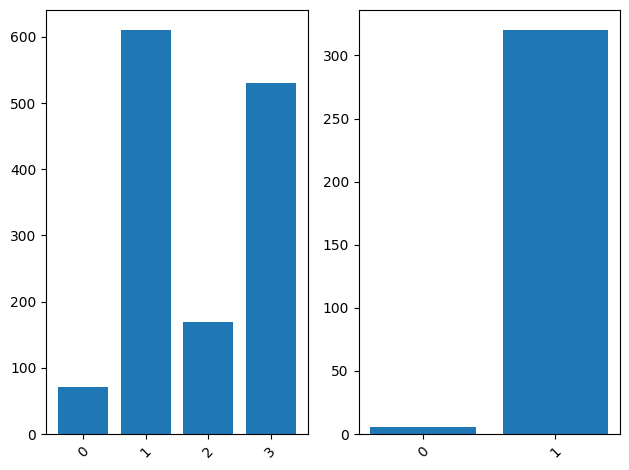

In [15]:

def plot_bar(df, label, select=None):
    dfs = df_select(df, *select) if select else [df]
    print(dfs)
    plt.figure(figsize=(30, 20))  
    ncols, nrows = 2, len(dfs) // 2 + len(dfs) % 2
    fig, axes = plt.subplots(nrows, ncols)

    for ax, df in zip(axes, dfs):
        ax.bar(*df_group_counts(df, label), label=label)
        ax.set_xticklabels(ax.get_xticks(), rotation=45)

    plt.bar()
    plt.tight_layout()
    # plt.legend()
    return plt.show()

# plot_bar(train_df, 'scenario', ['email', ])
# plt.bar(*df_group_counts(train_df, 'scenario'), label='scenario')
# plt.bar(*df_group_counts(df_select(train_df, 'scenario', ['play']), 'intent'))
plot_bar(df, 'intent', ('scenario', ['email', 'cooking']))


(<BarContainer object of 18 artists>,
 Index(['alarm', 'audio', 'calendar', 'cooking', 'datetime', 'email', 'general',
        'iot', 'lists', 'music', 'news', 'play', 'qa', 'recommendation',
        'social', 'takeaway', 'transport', 'weather'],
       dtype='object', name='scenario'))

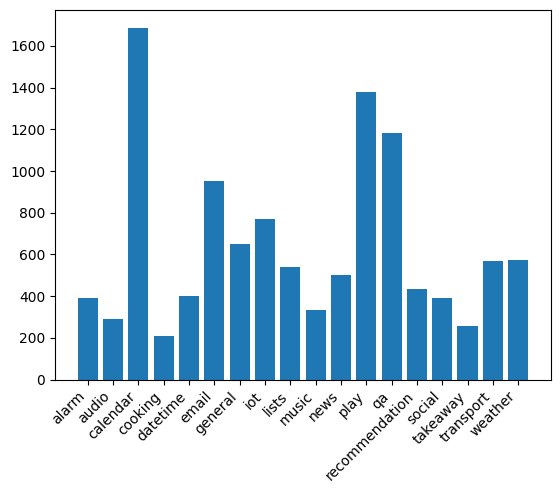

In [64]:
df_group_counts(train_df, 'scenario', bar_plot=True)

(<BarContainer object of 4 artists>,
 Index(['music_dislikeness', 'music_likeness', 'music_query', 'music_settings'], dtype='object', name='intent'))

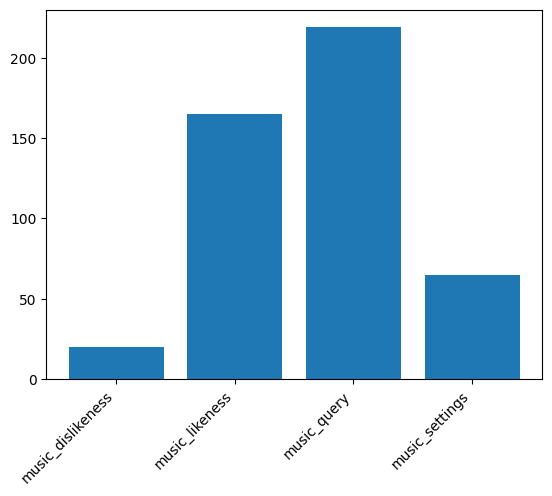

In [67]:
df_group_counts(df_select(df, 'scenario', ['music']), 'intent', True)

In [54]:
counts

NameError: name 'counts' is not defined

In [46]:
train_df.groupby('scenario').count()

,id,locale,partition,intent,utt,annot_utt,worker_id
scenario,,,,,,,
alarm,390,390,390,390,390,390,390
audio,290,290,290,290,290,290,290
calendar,1688,1688,1688,1688,1688,1688,1688
cooking,211,211,211,211,211,211,211
datetime,402,402,402,402,402,402,402
email,953,953,953,953,953,953,953
general,652,652,652,652,652,652,652
iot,769,769,769,769,769,769,769
lists,539,539,539,539,539,539,539


In [42]:
from datasets import Dataset

df_select(train_df, 'scenario', ['alarm']).groupby('intent')['id'].count()

intent
alarm_query     130
alarm_remove     78
alarm_set       182
Name: id, dtype: int64

In [29]:
train_df.head()

,id,locale,partition,scenario,intent,utt,annot_utt,worker_id
1,1,en-US,train,alarm,alarm_set,wake me up at nine am on friday,wake me up at [time : nine am] on [date : friday],1
2,2,en-US,train,alarm,alarm_set,set an alarm for two hours from now,set an alarm for [time : two hours from now],1
4,4,en-US,train,audio,audio_volume_mute,olly quiet,olly quiet,1
5,5,en-US,train,audio,audio_volume_mute,stop,stop,1
6,6,en-US,train,audio,audio_volume_mute,olly pause for ten seconds,olly pause for [time : ten seconds],1
